# Overview

This notebook provides a high-level overview of what we are trying to achieve.

## Workflow Goals

1. Discritize continuous point cloud observation locations $P(x,y,z)$ into discrete voxels $V(i,j,k)$.

1. Determine surface elevation, $E(i,j)$, for each voxel

1. Create a `DEM` of surface based on $E(i,j)$ field. 

1. Cluster $P(r,g,b)$ data into $N$ categories. Goal is to isolate "soil/stem" and "canopy" elements, as well as shadowed areas.

1. Determine point density and cluster membership density for each voxel.


## Load a sample point cloud for example purposes 

In [69]:
%matplotlib inline
from scipy.spatial import KDTree
import pandas as pd

In [70]:
filename = 'uhnb1_con_b_c_xyz.csv'
df = pd.read_csv(filename)

### Renormalize X and Y locations to 0,0 origin

In [71]:
df.X = df.X - df.X.min()
df.Y = df.Y - df.Y.min()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010104 entries, 0 to 1010103
Data columns (total 3 columns):
X    1010104 non-null float64
Y    1010104 non-null float64
Z    1010104 non-null float64
dtypes: float64(3)
memory usage: 23.1 MB


### Thin the data to only a 5x5 meter region

In [72]:
df = df.loc[(df['Z'] > .5)]

### Discritize P(x,y,z) into V(i,j,k)

In [87]:
from math import floor, log

dx = 0.5
dy = 0.5
dz = 0.5

df.X = (df.X/dx).astype(int)
df.Y = (df.Y/dy).astype(int)
df.Z = (df.Z/dz).astype(int)

voxels = df.groupby(['X','Y']).count()
print(voxels.head(10))

voxels = voxels.reset_index()
voxels.columns = ['X', 'Y', 'count']
voxels=voxels.pivot('X', 'Y')

Y=voxels.columns.levels[1].values
X=voxels.index.values
Z=voxels.values

voxels.describe()

                Z
X     Y          
0     2179072   6
16384 2162688   8
      2179072   8
32768 2146304   6
      2162688  11
49152 2129920   4
      2146304  12
      2162688   2
65536 2113536   3
      2129920  14


count                                                              \
Y       0       16384     32768     49152      65536      81920     98304     
count  2.000000     1.0  3.000000  3.000000   4.000000   2.000000  3.000000   
mean   8.000000     1.0  2.666667  4.333333   8.250000   8.500000  3.666667   
std    1.414214     NaN  1.527525  3.214550   4.924429   9.192388  4.618802   
min    7.000000     1.0  1.000000  2.000000   4.000000   2.000000  1.000000   
25%    7.500000     1.0  2.000000  2.500000   4.000000   5.250000  1.000000   
50%    8.000000     1.0  3.000000  3.000000   8.000000   8.500000  1.000000   
75%    8.500000     1.0  3.500000  5.500000  12.250000  11.750000  5.000000   
max    9.000000     1.0  4.000000  8.000000  13.000000  15.000000  9.000000   

                                         ...                          \
Y        114688     131072     147456    ...      4358144    4374528   
count   5.000000   5.000000   8.000000   ...    12.000000  13.000000   
mean    3.400000   8.000000   6.625000   ...    22.416667  21.076923   
std     3.714835   6.324555   6.232117   ...     6.331140   7.761674   
min     1.000000   1.000000   1.000000   ...     5.000000   4.000000   
25%     2.000000   3.000000   1.000000   ...    25.000000  25.000000   
50%     2.000000   7.000000   5.000000   ...    25.000000  25.000000   
75%     2.000000  14.000000  10.500000   ...    25.000000  25.000000   
max    10.000000  15.000000  16.000000   ...    25.000000  25.000000   

                                                                         \
Y        4390912    4407296    4423680    4440064    4456448    4472832   
count  13.000000  14.000000  13.000000  10.000000   7.000000   5.000000   
mean   21.461538  21.000000  19.461538  18.900000  16.428571   6.400000   
std     8.252428   8.735427   7.600607   9.158481   9.930712   5.899152   
min     1.000000   1.000000   3.000000   2.000000   1.000000   1.000000   
25%    25.000000  25.000000  14.000000  17.250000   9.000000   1.000000   
50%    25.000000  25.000000  24.000000  24.500000  21.000000   5.000000   
75%    25.000000  25.000000  25.000000  25.000000  25.000000  11.000000   
max    25.000000  25.000000  25.000000  25.000000  25.000000  14.000000   

                         
Y       4489216 4603904  
count  2.000000     1.0  
mean   2.000000     1.0  
std    1.414214     NaN  
min    1.000000     1.0  
25%    1.500000     1.0  
50%    2.000000     1.0  
75%    2.500000     1.0  
max    3.000000     1.0  

[8 rows x 252 columns]

70056


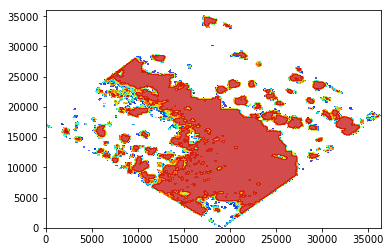

In [80]:
Xi,Yi = np.meshgrid(X, Y)

plt.contourf(Yi, Xi, Z, alpha=0.7, cmap=plt.cm.jet);

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

N1 = 10
N2 = 10
N3 = 10
ma = np.random.choice([0,1], size=(N1,N2,N3), p=[0.99, 0.01])

print(ma)